### variance test 2022/11/24~
- dual head encoder: (class,var)
- random bit encoder: Nbit->1bit, n-sample
- variance loss
- ~noised training~
----
- __used in a paper, KB-equation.__
----

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import itertools

/Users/na/miniforge3/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [68]:
class RBE(object):
    # binary random bit encoder
    def __init__(self,N):
        # N, size of bitstrings
        self.N=N

    def gen_all_bits(self,tensor=True):
        bits=np.zeros((2**self.N,1,self.N))
        for i in range(2**self.N):
            b=format(i,'b')
            bits[i,0,-len(b):]=list(map(int,b))
        bits=bits.astype(np.float32)
        if tensor is True: bits=torch.from_numpy(bits)
        return bits

    def gen_random_bits(self,n):
        # generate n bitstrings with a single template.
        # value x=1 if x<p else 0
        bits=(np.random.rand(n,1,self.N)<0.5).astype(np.float32)
        ans=(np.random.rand(n,1)<0.5).astype(np.float32)
        return bits,ans

    def return_bitans(self,bits,ans,tensor=True):
        if tensor is True:
            bits=torch.from_numpy(bits)
            ans=torch.from_numpy(ans)
        return bits,ans

    def gen_RBE(self,n,tensor=True):
        b,a=self.gen_random_bits(n)
        return self.return_bitans(b,a)

In [94]:
class FCN(nn.Module):
    def __init__(self,size=12,in_channel=1,ksize=3,out_channel=3,layerN=3,padding='same'):
        super(FCN,self).__init__()
        # backbone: simple 1D-convolution
        self.conv0=nn.Conv1d(in_channel,out_channel,ksize,padding=padding)
        self.convs=[nn.Conv1d(out_channel,out_channel,ksize,padding=padding) for i in range(layerN-1)]
        # feature output from the backbone input-size x out_channel
        self.size=size
        self.out_channel=out_channel
        self.in_channel=in_channel
        self.layerN=layerN
        self.fc1=nn.Linear(size*out_channel,1)
        self.fc2=nn.Linear(size*out_channel,1)
        self.S=nn.Sigmoid()

    def forward(self,x):
        x=F.elu(self.conv0(x))
        for c in self.convs: x=F.elu(c(x))
        x = x.view(-1,self.size*self.out_channel)
        x0,x1=self.fc1(x),self.fc2(x)
        mu,sig=self.S(x0),self.S(x1)
        return mu,sig

class Loss2(nn.Module):
    def __init__(self): # パラメータの設定など初期化処理を行う
        super(Loss2, self).__init__()

    def forward(self, mu, sig, Y): # モデルの出力と正解データ
        # log( 1/( sig*sqrt(2*pi) * exp( -(x-mu)^2/(2*sig^2) ) )
        # -log(sig)-log(pi)/2-(x-mu)^2/(2*sig^2)
        # -log(sig)-mse/(2*sig^2) + C
        err=mu-Y
        #print(err.shape,mu.shape,Y.shape)
        #mse=torch.sum(torch.square(mu-Y),1,keepdim=True)
        loss2=torch.mean(torch.log(sig)+err*err/(2*sig*sig))
        return loss2,torch.mean(err*err),torch.mean(sig*sig)

class Loss1(nn.Module):
    def __init__(self): # パラメータの設定など初期化処理を行う
        super(Loss1, self).__init__()

    def forward(self, mu, sig, Y): # モデルの出力と正解データ
        # log( 1/(2*sig) * exp( -|x-mu|/sig ) )
        # -log(sig) - |x-mu|/sig + C
        # -log(sig) - L1/sig
        err=torch.abs(mu-Y)
        loss1=torch.mean(torch.log(sig)+err/sig)
        return loss1,torch.mean(err*err),torch.mean(sig*sig*2)

----
__kernel scale fitting__

In [763]:
def get_wXY(X,Y,hmx=8):
    xn,yn=X.detach().cpu().numpy(),Y.detach().cpu().numpy()
    H=np.zeros((xn.shape[0],xn.shape[0]))
    for i,j in itertools.combinations(range(xn.shape[0]),2):
        H[i,j]=H[j,i]=np.sum(np.abs(xn[i,0,:]-xn[j,0,:]))
    C,M=np.zeros((xn.shape[0],hmx)),np.zeros((xn.shape[0],hmx))
    for i,h in itertools.product(range(xn.shape[0]),range(hmx)):
        idx=H[i,:]==h
        C[i,h]=np.sum(idx)
        M[i,h]=np.mean(yn[idx,0]) if np.sum(idx)>0 else -1
    return C,M

def get_wmean(C,M,s):
    w=np.exp(-s*np.arange(C.shape[1]))
    cmw=C*M*w
    return np.sum(cmw,axis=1)/np.sum(C*w,axis=1)

def solve_ks(C,M,mu,ds=0.01,smx=2):
    ms=mu.detach().cpu().numpy()
    sv=[]
    for s in np.arange(0,smx,ds):
        wm=get_wmean(C,M,s)
        v=np.mean(np.sum(np.abs(wm-ms[:,0])))
        sv.append([s,v])
    sv=np.array(sv)
    ii=np.argmin(sv[:,1])
    sopt=sv[ii,0]
    return sopt

C,M=get_wXY(X,Y)
solve_ks(C,M,mu)

0.9500000000000001

----
__kernel scale plot__  
1. ( <$|y_i-\mu_i|$>,<$\sigma_i$> ) : along the loss potential?  
2. ( <$|y_i-\mu_i(\beta)|$>,<$\sigma(\beta)$> ): optimal trajectory along the kernel scale

In [631]:
Ps=[]

In [792]:
learning_rate=0.1
momentum=0.0
size=8
layerN=3
RBE_sample=20

rbe=RBE(size)
xall=rbe.gen_all_bits()
X,Y=rbe.gen_RBE(RBE_sample)
fcn=FCN(size=size,layerN=layerN)

optimizer=opt.SGD(fcn.parameters(),lr=learning_rate,momentum=momentum)
mseloss=nn.MSELoss()
L1loss=nn.L1Loss()
Lloss=Loss1()
Gloss=Loss2()

Finished Training


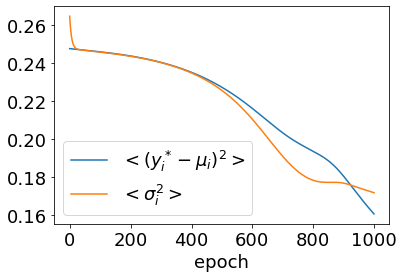

Text(0, 0.5, '-\\alpha')

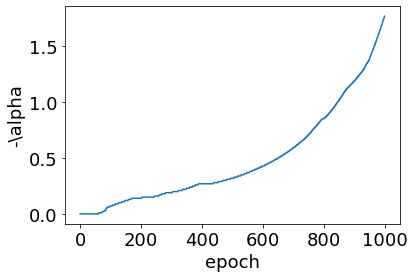

In [793]:
emx=1000
#print(rbe.get_interaction_RBE(b=1.0))
pv=[]
preds=[]
whist=[]
C,M=get_wXY(X,Y)
sopts=[]
for e in range(emx):
    optimizer.zero_grad()

    mu,s=fcn(X)
    er,sg=(mu-Y).detach().cpu().numpy(),s.detach().cpu().numpy()
    #preds.append([np.mean(np.abs(er),axis=0),np.mean(sg,axis=0)])
    preds.append([np.abs(er),sg])
    #L,err2,var=Lloss(mu,s,Y)
    L,err2,var=Gloss(mu,s,Y)
    pv.append([L.item(),err2.item(),var.item()])
    L.backward()
    #err2.backward()
    optimizer.step()
    sopt=solve_ks(C,M,mu,ds=0.01,smx=5)
    sopts.append(sopt)
    #if e%100==99:
        #m,s=fcn(xall)
        #w=estimate_w(X,Y,xall,m,s).tolist()
        #whist.append([e]+w)

Ps.append(preds)
print('Finished Training')
pv=np.array(pv)
ew=np.array(whist)
#plt.plot(pv[:,0],label='loss')
plt.plot(pv[:,1],label=r'$<(y_i^*-\mu_i)^2>$')
plt.plot(pv[:,2],label=r'$<\sigma_i^2>$')
plt.xlabel('epoch')
#plt.plot(ew[:,0],ew[:,1],label='w')
plt.legend()
plt.show()
plt.plot(sopts)
plt.xlabel('epoch')
plt.ylabel(r'-\alpha')

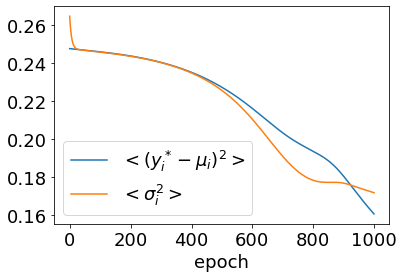

Text(0, 0.5, '$\\alpha$')

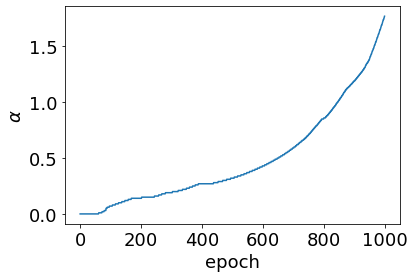

In [797]:
plt.plot(pv[:,1],label=r'$<(y_i^*-\mu_i)^2>$')
plt.plot(pv[:,2],label=r'$<\sigma_i^2>$')
plt.xlabel('epoch')
#plt.plot(ew[:,0],ew[:,1],label='w')
plt.legend()
plt.show()
#plt.subplots_adjust(left=0.2,bottom=0.2)
#plt.savefig('N20_var2.eps')
#plt.close()
plt.plot(sopts)
plt.xlabel('epoch')
plt.ylabel(r'$\alpha$')
#plt.subplots_adjust(left=0.2,bottom=0.2)
#plt.savefig('N20_alpha.eps')
#plt.close()

/var/folders/82/ysn2wf8x1x9dt6md300frm700000gn/T/ipykernel_11978/3624144286.py:7: RuntimeWarning: divide by zero encountered in log
  return -np.log(sg)-(x-mu)*(x-mu)/(2*sg*sg)
/var/folders/82/ysn2wf8x1x9dt6md300frm700000gn/T/ipykernel_11978/3624144286.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  return -np.log(sg)-(x-mu)*(x-mu)/(2*sg*sg)
/var/folders/82/ysn2wf8x1x9dt6md300frm700000gn/T/ipykernel_11978/3624144286.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return -np.log(sg)-(x-mu)*(x-mu)/(2*sg*sg)


(1000, 2, 20, 1)


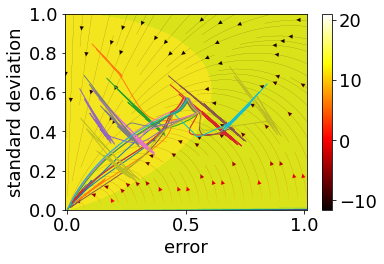

(20, 1, 8)


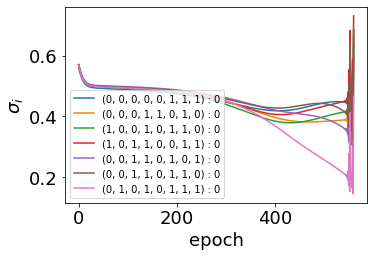

In [706]:
def gauss_dist(x,mu,sg):
    xx=(x-mu)/sg
    return np.exp(-xx*xx/2)/sg
    return np.exp(-xx*xx/2)/(sg*np.sqrt(2*np.pi))

def log_gauss(x,mu,sg):
    return -np.log(sg)-(x-mu)*(x-mu)/(2*sg*sg)

sgs=np.linspace(0,1,num=300)
mus=np.linspace(-0.05,1.05,num=300)
M=np.zeros((len(sgs),len(mus)))
# -log(sig)-mse/(2*sig^2) + C
for (i,s),(j,m) in itertools.product(enumerate(sgs),enumerate(mus)):
    #M[i,j]=np.log(gauss_dist(0,m,s))
    M[i,j]=log_gauss(0,m,s)

#plt.imshow(mus,sgs,M)


plt.rcParams["font.size"] = 18

plt.contourf(mus,sgs,M,levels=30)
#plt.colorbar()
dm,ds=0.5*(mus[1]-mus[0]),0.5*(sgs[1]-sgs[0])

U,V=M[:-1,1:]-M[:-1,:-1],M[1:,:-1]-M[:-1,:-1]

plt.streamplot(mus[:-1]+dm,sgs[:-1]+ds,U,V,color=np.log(U*U+V*V),cmap=plt.cm.hot,density=1.0,linewidth=0.1)
plt.colorbar()
plt.xlim(-0.01,1.01)
plt.xlabel('error')
plt.ylabel('standard deviation')
#seed_points=np.array([[0,0.1,0.2,0.3,0.4],[0.8,0.25,0.25,0.25,0.25]])
#plt.streamplot(mus[:-1]+dm,sgs[:-1]+ds,U,V,color=np.log(U*U+V*V),cmap=plt.cm.hot,start_points=seed_points.T)
#plt.colorbar()
Tmx=560
for ps in Ps:
    xy=np.array(ps)
    print(xy.shape)
    #idx=np.abs(xy[1:,1]-xy[:-1,1])<0.0001
    #imx=np.amax(np.where(idx))
    #plt.plot(np.mean(xy[:,0,:,0],axis=1),np.mean(xy[:,1,:,0],axis=1),lw=3)
    for i in range(xy.shape[2]):
        plt.plot(xy[:Tmx,0,i,0],xy[:Tmx,1,i,0],lw=1)
    #print(xy[-1,0],xy[-1,1],imx)
plt.subplots_adjust(left=0.2,bottom=0.2)
#plt.savefig('point_training_N20.eps')
#plt.close()
plt.show()
for ps in Ps:
    xy=np.array(ps)
    xnp,ynp=X.detach().cpu().numpy(),Y.detach().cpu().numpy()
    print(xnp.shape)
    for i in range(xy.shape[2]):
        l=str(tuple(xnp[i,0,:].astype(np.uint8).tolist()))+' : '+str(ynp[i].astype(np.uint8)[0])
        #if True:
        #if xy[549,1,i,0]<0.01:
        if np.abs(xy[547,1,i,0]-xy[544,1,i,0])>0.01:
            plt.plot(xy[:560,1,i,0],label=l)
plt.xlabel('epoch')
#plt.ylabel(r'$\mu_i$')
plt.ylabel(r'$\sigma_i$')
plt.legend(fontsize=10)
plt.subplots_adjust(left=0.2,bottom=0.2)
#plt.savefig('mu_dyn.eps')
#plt.savefig('sigma_dyn_first_collapse.eps')
#plt.close()

__memo 20230126__  
1. $\mu_i$ moves along the KB: $\mu_i\sim\sum K_{ij}(t)y_j$
2. $\sigma_i$ moves along the local vector field, $dL(\mu_i,\sigma_i)/d\sigma_i$, with scaled kernel interaction.

--> KB for $\sigma_i$: $\propto\sum K_{ij}(t)|y_j-\mu_i^*|$  or $\sum K_{ij}(t)|y_j-\mu_i^*|$ ?

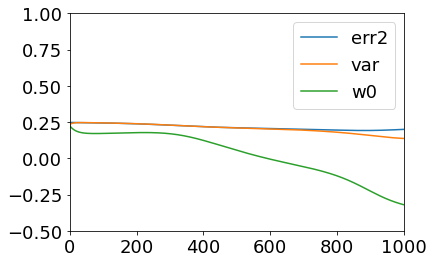

In [732]:
plt.plot(pv[:,1],label='err2')
plt.plot(pv[:,2],label='var')
plt.plot(ew[:,0],ew[:,1],label='w0')
#plt.plot(ew[:,0],ew[:,2],label='w1')
plt.ylim(-0.5,1.0)
plt.xlim(0,1000)
plt.legend()
plt.show()

----
__kernel size analysis__

In [285]:
m,s=fcn(xall)

In [719]:
def tonumpy(x): return x.detach().cpu().numpy().copy()

def make_dict(X,Y):
    xn,yn=tonumpy(X),tonumpy(Y)
    #print(xn.shape,yn.shape)
    xy_dict={}
    for i in range(xn.shape[0]):
        key=tuple(xn[i,0,:].tolist())
        val=yn[i,0]
        xy_dict[key]=xy_dict.get(key,[])+[val]
    return xy_dict

def get_H(k1,k2): return np.sum(np.abs(np.array(k1)-np.array(k2))).astype(np.int32)

def get_mdict(xy_dict,hmx=1):
    mdict={}
    for k1,v1 in xy_dict.items():
        vh={0:v1,1:[]}
        for k2,v2 in xy_dict.items():
            h=get_H(k1,k2)
            if 0<h<=hmx: vh[h]=vh.get(h,[])+v2
        mdict[k1]=vh
    return mdict

def estimate_w(X,Y,xall,m,s):
    xy_data=make_dict(X,Y)
    xy_pred=make_dict(xall,m)
    xy_dataM=get_mdict(xy_data,hmx=1)
    xs_pred=make_dict(xall,s)
    ws=[]
    for k,v in xy_dataM.items():
        pm,ps=xy_pred[k][0],xs_pred[k][0]
        #sum(v[0])+w*np.sum(v[1])=pm|V[0]|+w*pm|V[1]|
        #(a+b*w)^2->0
        #a=sum(v[0])-pm|V[0]|
        #b=np.sum(v[1])-pm|V[1]|
        #2b(a+b*w)=2ab+2bbw
        ws.append([np.sum(v[i])-pm*len(v[i]) for i in range(len(v))])
        #a=np.sum(v[i])-pm*len(v[i])
        #b=np.sum(v[1])-pm*len(v[1])
        #ws.append([a,b])
        #w=(np.sum(v[0])-pm*len(v[0]))/(pm*len(v[1])-np.sum(v[1]))
        #ws.append(w)
    ws=np.array(ws)
    pI=np.linalg.pinv(ws[:,1:])
    return -np.matmul(pI,ws[:,0])
    #A,B=np.sum(ws[:,0]),np.sum(ws[:,1])
    #return A/B

estimate_w(X,Y,xall,m,s)

array([0.07217379])

----
__massive test__


In [216]:
learning_rate=0.1
momentum=0.0
size=8
layerN=3
RBE_sample_mx=300
emx=2000
rbe=RBE(size)
xall=rbe.gen_all_bits()

loss_all=[]
for N in range(50,RBE_sample_mx):
    X,Y=rbe.gen_RBE(N)
    fcn=FCN(size=size,layerN=layerN)
    optimizer=opt.SGD(fcn.parameters(),lr=learning_rate,momentum=momentum)
    mseloss=nn.MSELoss()
    L1loss=nn.L1Loss()
    Lloss=Loss1()
    Gloss=Loss2()
    
    loss_vect=[]
    for e in range(emx):
        optimizer.zero_grad()
        mu,s=fcn(X)

        #L,err2,var=Lloss(mu,s,Y)
        L,err2,var=Gloss(mu,s,Y)
        loss_vect.append([L.item(),err2.item(),var.item()])
        L.backward()
        optimizer.step()
    loss_all.append(loss_vect)
    print(N,abs(loss_vect[-1][1]-loss_vect[-1][2]))

50 0.0017491132020950317
51 0.1549815833568573
52 0.1468372941017151
53 0.10106618702411652
54 0.0015801787376403809
55 0.00886949896812439
56 0.2325691282749176
57 0.2826916426420212
58 0.0022732317447662354
59 0.0028897225856781006
60 nan
61 0.002718508243560791
62 nan
63 0.006339177489280701
64 0.015812695026397705
65 nan
66 0.00025281310081481934
67 0.0014506727457046509
68 0.085184246301651
69 0.06786277890205383
70 0.0004961192607879639
71 0.00010316073894500732
72 0.0016430020332336426
73 0.0018396228551864624
74 0.00023439526557922363
75 0.00046521425247192383
76 0.00264836847782135
77 0.002422019839286804
78 0.0017432719469070435
79 0.0015699714422225952
80 0.0012184381484985352
81 0.0076496899127960205
82 0.001013636589050293
83 0.0006026923656463623
84 1.65402889251709e-05
85 0.005096316337585449
86 3.3348798751831055e-05
87 0.0024018585681915283
88 0.0010750293731689453
89 0.000692903995513916
90 0.00014822185039520264
91 0.001290053129196167
92 0.0003564804792404175
93 0.0

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


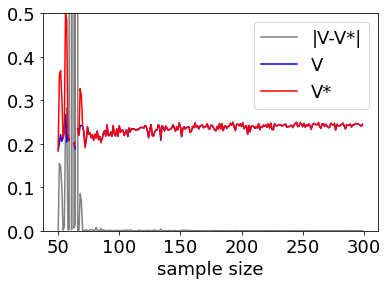

In [368]:
def plot_loss_all(los_all,xmn=50,xmx=300,errV=100,fname=None):
    Lall=np.array(los_all)
    err=np.abs(Lall[:,-1,1]-Lall[:,-1,2])
    idx=np.isnan(err)
    err[idx]=errV
    #plt.bar(range(xmn,xmx),err,label='|V-V*|',width=2)
    plt.plot(range(xmn,xmx),err,label='|V-V*|',color='gray')
    plt.plot(range(xmn,xmx),Lall[:,-1,1],label='V',color='blue')
    plt.plot(range(xmn,xmx),Lall[:,-1,2],label='V*',color='red')
    plt.ylim(0,0.5)
    #plt.ylabel('V-V*')
    plt.xlabel('sample size')
    plt.legend()
    if fname is not None:
        plt.subplots_adjust(bottom=0.2)
        plt.savefig(fname)
        plt.close()
    else: plt.show()

fname='density_transition.eps'
plt.rcParams["font.size"] = 18
plot_loss_all(loss_all,fname=fname)
plot_loss_all(loss_all)

----
__massive 2__: effect of emx

In [369]:
learning_rate=0.1
momentum=0.0
size=8
layerN=3
RBE_sample_mx=150
emx0,emx1=2000,5001
rbe=RBE(size)
xall=rbe.gen_all_bits()

loss_alls=[]
for emx in range(emx0,emx1,100):
    loss_all=[]
    for N in range(50,RBE_sample_mx):
        X,Y=rbe.gen_RBE(N)
        fcn=FCN(size=size,layerN=layerN)
        optimizer=opt.SGD(fcn.parameters(),lr=learning_rate,momentum=momentum)
        mseloss=nn.MSELoss()
        L1loss=nn.L1Loss()
        Lloss=Loss1()
        Gloss=Loss2()
    
        loss_vect=[]
        for e in range(emx):
            optimizer.zero_grad()
            mu,s=fcn(X)

            #L,err2,var=Lloss(mu,s,Y)
            L,err2,var=Gloss(mu,s,Y)
            loss_vect.append([L.item(),err2.item(),var.item()])
            L.backward()
            optimizer.step()
        loss_all.append(loss_vect)
        print(emx,N,abs(loss_vect[-1][1]-loss_vect[-1][2]))
    loss_alls.append(loss_all)
    #print(N,abs(loss_vect[-1][1]-loss_vect[-1][2]))

2000 50 0.020480722188949585
2000 51 0.005680859088897705
2000 52 0.00025957822799682617
2000 53 nan
2000 54 0.07434333860874176
2000 55 0.01555834710597992
2000 56 0.004844695329666138
2000 57 0.00025582313537597656
2000 58 0.00011074542999267578
2000 59 0.22091394662857056
2000 60 0.000571027398109436
2000 61 0.006165340542793274
2000 62 0.0009392648935317993
2000 63 0.21295583248138428
2000 64 0.00034908950328826904
2000 65 0.000165596604347229
2000 66 0.0013880431652069092
2000 67 0.013548403978347778
2000 68 0.04156564176082611
2000 69 0.00011259317398071289
2000 70 0.0026222020387649536
2000 71 0.002908572554588318
2000 72 0.006747215986251831
2000 73 0.0013061314821243286
2000 74 0.0011756718158721924
2000 75 0.000286102294921875
2000 76 0.10533066093921661
2000 77 0.00016123056411743164
2000 78 0.0022651106119155884
2000 79 0.0005002319812774658
2000 80 0.00048013031482696533
2000 81 0.0018486082553863525
2000 82 0.0010018646717071533
2000 83 0.004521161317825317
2000 84 0.0010

In [419]:
d_v=[]
for l in loss_alls:
    v1=np.array(l)[:,-1,1]
    v2=np.array(l)[:,-1,2]
    d_v.append(np.abs(v1-v2))
#vars=np.array(loss_alls)
#v=np.array(loss_alls[-3])
print(v.shape)
#print(vars.shape,v.shape)
#plt.imshow(vars)
#print(loss_alls[0][0][0],loss_alls[-1][0][0])
#plt.plot(v[0,:,2])
#print(v[0,1999,2])
d_v=np.array(d_v)
d_v.shape

(100, 4800, 3)


(31, 100)

In [1]:
idx=np.isnan(d_v)
d_v[idx]=0.5
d_v[d_v>0.5]=0.5
plt.imshow(d_v,aspect=2)
plt.colorbar()
ax=plt.gca()
from matplotlib.ticker import ScalarFormatter


ax.set_yticks(np.arange(0,31,10),[2.0,3.0,4.0,5.0])
ax.set_xticks(np.arange(0,100,20),np.arange(50,150,20))
ax.set_xlabel('sample size')
ax.set_ylabel('emx [x1000]')

#plt.savefig('density_transition2.eps')
#plt.close()
#ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#ax.ticklabel_format(style="sci",  axis="y",scilimits=(0,0))

NameError: name 'np' is not defined

----
stat test

In [12]:
learning_rate=0.1
momentum=0.0
size=8
layerN=3
emx=10000
itrmx=200

0 0.0025 0.0250726266534259 0.8334300139398857
1 0.005 0.016563784204255107 0.9643605494735265
2 0.0075 0.00628145382386822 0.9703443912468335
3 0.01 0.004079640154043737 0.9789679204355372
4 0.0125 0.006346689081324538 0.9795559133397471
5 0.015 0.014334619961950356 0.9696777034041905
6 0.0175 0.034833711502412074 0.9528181302665485
7 0.02 0.008275463290389177 0.9799687383670617
8 0.0225 0.016781537909964863 0.9766402639256845
9 0.025 0.020273870814842967 0.9788268687937518
10 0.0275 0.00788443329480669 0.9857903977195817
11 0.03 0.004943321808017295 0.990469021938815
12 0.0325 0.003947986735559383 0.9897320481102065
13 0.035 0.015976108390598077 0.9758010214626198
14 0.0375 0.026181402416232347 0.9709694724507851
15 0.04 0.006224164204238431 0.9844186152089941
16 0.0425 0.007210876526907607 0.9853779851328031
17 0.045 0.006240497691927059 0.9903345542378945
18 0.0475 0.011998003274442205 0.9836391184589651
19 0.05 0.006390044580749142 0.9869777868289761
20 0.0525 0.003588407062241991

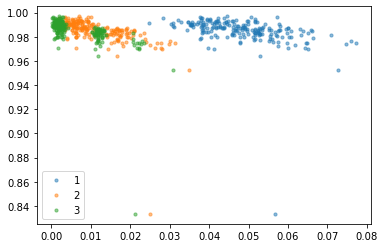

In [13]:
Dmtx,Val=[],[]
ss=[]
for i in range(itrmx):
    rbe=RBE(size)
    xall=rbe.gen_all_bits()
    X,Y,x0,y0,x1,y1=rbe.gen_biased_RBE(1,100,0.1,0.5)
    fcn=FCN(size=size,layerN=layerN)

    optimizer=opt.SGD(fcn.parameters(),lr=learning_rate,momentum=momentum)
    mseloss=nn.MSELoss()
    celoss=nn.CrossEntropyLoss()

    D,Didx=rbe.get_interaction_RBE(b=2.0)
    pv=[]
    # s1=0.001*(1.032**i)
    s1=0.0025*(1+i)
    ss.append(s1)
    for e in range(emx):
        optimizer.zero_grad()
        #s1=(1-np.exp(-e*0.00001))*0.99+0.01
        X,Y,x0_,y0_,x1_,y1_=rbe.next_biased_RBE2(1.0,s1)
        p,s=fcn(X)
        L=celoss(p,Y)
        L.backward()
        optimizer.step()
        if e%100==99:
            #S=0.0
            p,s=fcn(x0)
            snp=s.to('cpu').detach().numpy().copy()
            S0=np.sum(snp[:,0])
            p,s=fcn(x1)
            snp=s.to('cpu').detach().numpy().copy()
            S1=np.sum(snp[:,1])
            pv.append([(S0+S1)/101,S0,S1/100])
    Dmtx.append(D)
    sm=np.array(pv)[:,0]
    #Val.append(np.mean(sm[100:]))
    Val.append(np.mean(sm))
    print(i,s1,Didx,Val[-1])

for b in range(1,4):
    Dexp=np.exp(-b*np.array(Dmtx))
    Kint=np.mean(np.mean(Dexp,axis=2),axis=1)
    plt.scatter(Kint,Val,label=b,s=10,alpha=0.5)
plt.legend()
plt.show()

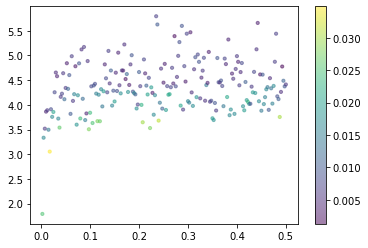

In [16]:
for b in np.arange(2,3,500):
    Dexp=np.exp(-b*np.array(Dmtx))
    Kint=np.mean(np.mean(Dexp,axis=2),axis=1)
    #plt.scatter(Kint,Val,c=ss,s=10,alpha=0.5)
    #plt.scatter(Kint,-np.log(1-np.array(Val)),c=ss,s=10,alpha=0.5)
    plt.scatter(ss,-np.log(1-np.array(Val)),c=Kint,s=10,alpha=0.5)
    #plt.scatter(ss,Val,c=Kint,s=10,alpha=0.5)
plt.colorbar()
#plt.legend()
plt.show()

----

In [ ]:
p,s=fcn(x0)
print(s)
p,s=fcn(x1)
print(s)
p,s=fcn(xall)
print(s)